In [221]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import scipy.stats as stats
import h2o
import matplotlib.pyplot as plt
%matplotlib inline

## Data Exploration

In [222]:
# load data
train = pd.read_csv("./data/train.csv")
print("data shape: ", train.shape, "\n")
print("data sample: \n", train.head(2), "\n")
print("Total number of duplicated rows: ", sum(train.duplicated(keep=False)))
for column in train.columns:
    print("Missing values of", column, ": ", sum(pd.isna(train[column])))


data shape:  (10886, 12) 

data sample: 
               datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40   

Total number of duplicated rows:  0
Missing values of datetime :  0
Missing values of season :  0
Missing values of holiday :  0
Missing values of workingday :  0
Missing values of weather :  0
Missing values of temp :  0
Missing values of atemp :  0
Missing values of humidity :  0
Missing values of windspeed :  0
Missing values of casual :  0
Missing values of registered :  0
Missing values of count :  0


### Data Fields
datetime - hourly date + timestamp<br/> 
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter<br/>
holiday - whether the day is considered a holiday<br/>
workingday - whether the day is neither a weekend nor holiday<br/>
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy<br/>
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br/>
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br/>
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br/>
temp - temperature in Celsius<br/>
atemp - "feels like" temperature in Celsius<br/>
humidity - relative humidity<br/>
windspeed - wind speed<br/>
casual - number of non-registered user rentals initiated<br/>
registered - number of registered user rentals initiated<br/>
count - number of total rentals

### Univariate 
Explore distribution of variables.

In [161]:
# partition columns into categorical and continuous. Note that datetime is hard to visualize. 
cat_cols = ["season", "holiday", "workingday", "weather"]
con_cols = list(filter(lambda x: x not in cat_cols, (train.columns)))
con_cols.remove("datetime")
con_cols.remove("registered")
con_cols.remove("casual")

def showCat(cat_col):
    print("Stats about " + cat_col + ": ")
    print(train[cat_col].describe())
    ax = sns.countplot(x = cat_col, data = train, color = "c")
    plt.show()
    
def showCon(con_col):
    print("Stats about " + con_col)
    print(train[con_col].describe())
    ax = sns.distplot(train[con_col], kde = False)
    plt.show()


Stats about season: 
count    10886.000000
mean         2.506614
std          1.116174
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: season, dtype: float64


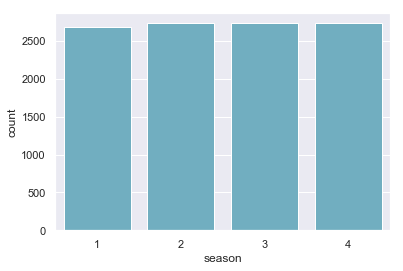

Stats about holiday: 
count    10886.000000
mean         0.028569
std          0.166599
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: holiday, dtype: float64


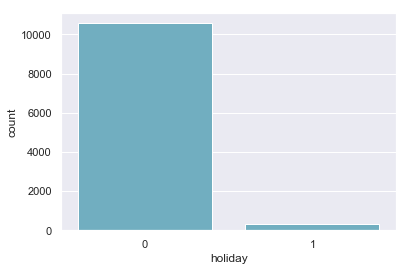

Stats about workingday: 
count    10886.000000
mean         0.680875
std          0.466159
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: workingday, dtype: float64


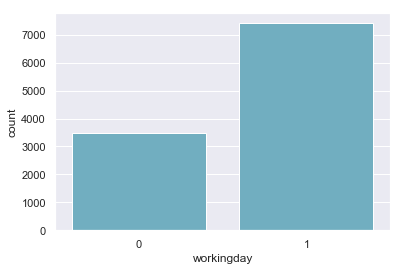

Stats about weather: 
count    10886.000000
mean         1.418427
std          0.633839
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: weather, dtype: float64


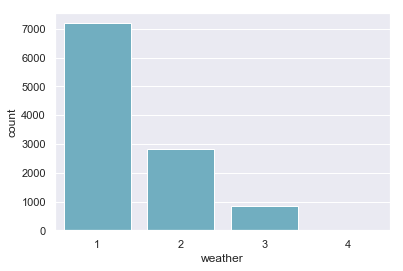

In [162]:
# categorical data
for cat_col in cat_cols:
    showCat(cat_col)

Stats about temp
count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64


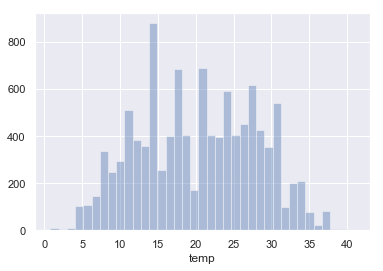

Stats about atemp
count    10886.000000
mean        23.655084
std          8.474601
min          0.760000
25%         16.665000
50%         24.240000
75%         31.060000
max         45.455000
Name: atemp, dtype: float64


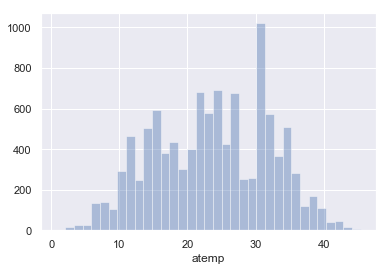

Stats about humidity
count    10886.000000
mean        61.886460
std         19.245033
min          0.000000
25%         47.000000
50%         62.000000
75%         77.000000
max        100.000000
Name: humidity, dtype: float64


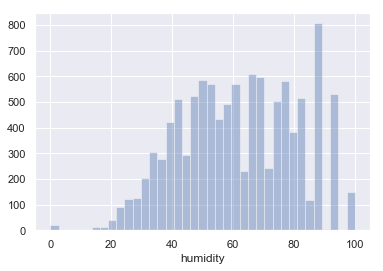

Stats about windspeed
count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64


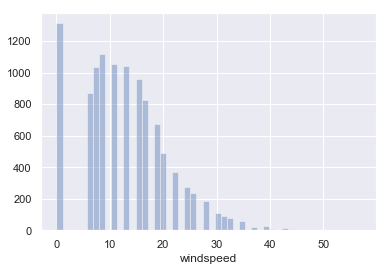

Stats about count
count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64


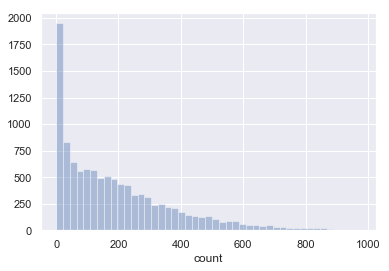

In [163]:
# Continuous data
for con_col in con_cols:
    showCon(con_col)

Note that variable Casual, Registered, Count are all highy skewed data. They may need to be transformed before used inthe model. Further exploration of the three variables is as below:

Transformed count


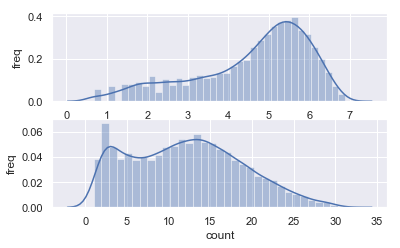

In [164]:
def showConTrans(con_col):
    print("Transformed " + con_col)
    fig = plt.figure()
    fig.subplots_adjust(top=0.8)
    ax0 = fig.add_subplot(211)
    ax0.set_ylabel('freq')
    ax0.set_xlabel("log-transformed " + con_col)
    ax0 = sns.distplot(np.log(train[con_col] + 1))
    
    ax1 = fig.add_subplot(212)
    ax1.set_ylabel('freq')
    ax1.set_xlabel("sqrt-transformed " + con_col)
    ax1 = sns.distplot(np.sqrt(train[con_col]))  
    plt.show()
    
showConTrans("count")
    

The results gave no normal distribution. 

### Bivariate

One important thing is to check how variables change with the time. 
Extract year, month, date, hour from train["datetime"] to visualize the data with time change. 

In [223]:
def extractTimeStamp(df):
    dates = pd.DatetimeIndex(df["datetime"])
    df["year"] = dates.year
    df["month"] = dates.month
    df["day"] = dates.day
    df["hour"] = dates.hour
extractTimeStamp(train)

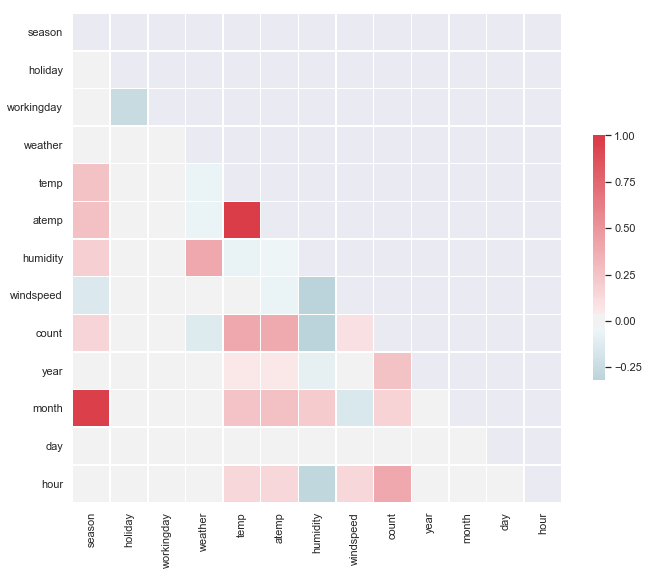

In [168]:
# Calculate the correlation and draw the heapmap.
train_notime = train[cat_cols + con_cols + ["year", "month", "day", "hour"]]
corr = train_notime.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

As we can see from the heapmap, the atemp and temp are highly correlated, season and month are very related(obviously). Later in the model part, atemp may need to be removed to test the performance since its correlation with temp.

Text(0.5, 1.0, 'Correlation between temp and atemp')

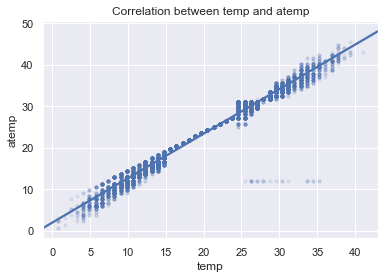

In [169]:
# This is to visulize the linear correlation between atemp and temp
sns.set(color_codes=True)
ax = sns.regplot(x="temp", y="atemp", data=train, ci = 95, scatter_kws={"s": 10, "alpha": 0.1})
ax.set_title('Correlation between temp and atemp')

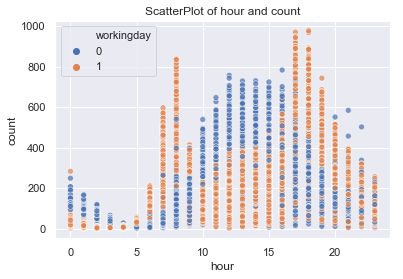

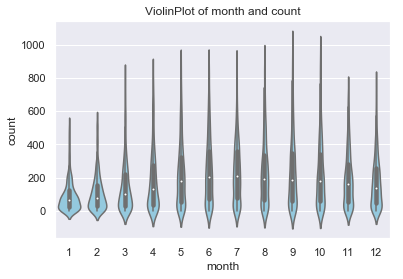

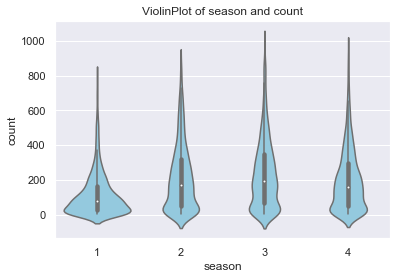

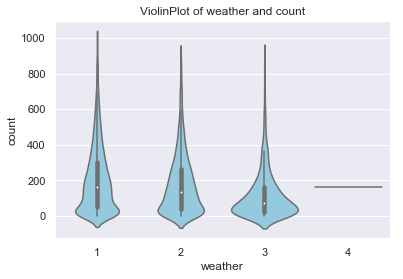

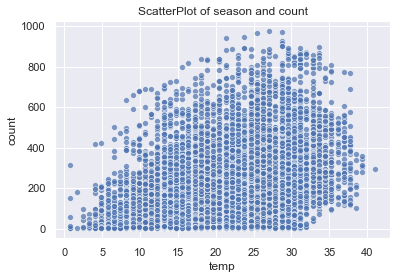

In [170]:
# Visualize the data casual, registered, count changing with time
con_col = "count"
fig = plt.figure()
# boxplot with hour
ax = sns.scatterplot(x="hour", y=con_col, hue = "workingday", data=train, alpha = 0.7)
ax.set_title("ScatterPlot of " + "hour" + " and " + con_col)
plt.show()

# boxplot with month
ax = sns.violinplot(x="month", y=con_col, data=train, color="skyblue")
ax.set_title("ViolinPlot of " + "month" + " and " + con_col)
plt.show()

# boxplot with season
ax = sns.violinplot(x="season", y=con_col, data=train, color="skyblue")
ax.set_title("ViolinPlot of " + "season" + " and " + con_col)
plt.show()

# boxplot with season
ax = sns.violinplot(x="weather", y=con_col, data=train, color="skyblue")
ax.set_title("ViolinPlot of " + "weather" + " and " + con_col)
plt.show()

# boxplot with weather
ax = sns.scatterplot(x="temp", y=con_col, data=train, alpha = 0.7)
ax.set_title("ScatterPlot of " + "season" + " and " + con_col)
plt.show()
    


It's obvious that count number is very related with season, weather and workingday. 

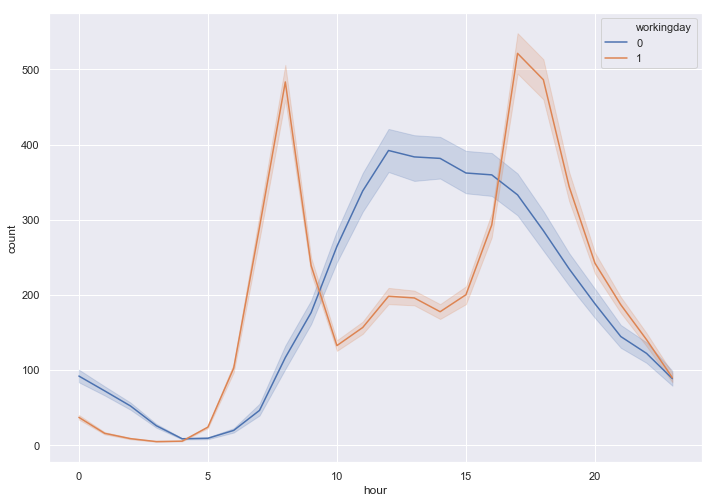

In [372]:
# Plot the responses for different events and regions
ax = sns.lineplot(x="hour", y="count",
             hue="workingday",
             data=train)
ax.set_title("")
plt.show()

When it's a working day, we can see two peak time at around 8am and 5pm. 

### Fit a Model in Train 

In [218]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.1" 2018-10-16; OpenJDK Runtime Environment 18.9 (build 11.0.1+13); OpenJDK 64-Bit Server VM 18.9 (build 11.0.1+13, mixed mode)
  Starting server from /usr/local/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/74/v8glp1bd1gqfb8x1_s8g3n400000gn/T/tmpdq6tz6f1
  JVM stdout: /var/folders/74/v8glp1bd1gqfb8x1_s8g3n400000gn/T/tmpdq6tz6f1/h2o_xuanguo_started_from_python.out
  JVM stderr: /var/folders/74/v8glp1bd1gqfb8x1_s8g3n400000gn/T/tmpdq6tz6f1/h2o_xuanguo_started_from_python.err
  Server is running at http://127.0.0.1:54329
Connecting to H2O server at http://127.0.0.1:54329... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.6
H2O cluster version age:,17 days
H2O cluster name:,H2O_from_python_xuanguo_2e3yqs
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [224]:
train = train.drop(columns = ["datetime", "registered", "casual"])
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, test_size=0.2)
traindata = h2o.H2OFrame(train)
testdata = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [366]:
# Set predictor and response variables
dependent = "count"
predictors = ['season', 'holiday', 'workingday', 'weather', 'atemp', 'temp','humidity', 
       'windspeed', 'year', 'month', 'day', 'hour']


# Simple GBM
gbm = H2OGradientBoostingEstimator(balance_classes=True,
                                        ntrees         =3,
                                        max_depth      =1,
                                        learn_rate     =0.1,
                                        min_rows       =2)

gbm.train(x               =predictors,
               y               =dependent,
               training_frame  =traindata,
               validation_frame=testdata)

# Complex GBM
gbm2 = H2OGradientBoostingEstimator(balance_classes=True,
                                         ntrees         =60,
                                         max_depth      =10,
                                         learn_rate     =0.1,
                                         min_rows       =2)

gbm2.train(x               =predictors,
           y               =dependent,
           training_frame  =traindata,
           validation_frame=testdata)

# Simple Random Forest
rf = H2ORandomForestEstimator(ntrees         =5,
                                   max_depth      =2,
                                   balance_classes=True)

rf.train(x               =predictors,
         y               =dependent,
         training_frame  =traindata,
         validation_frame=testdata)

# Complex Random Forest
rf2 = H2ORandomForestEstimator(ntrees         =100,
                               max_depth      =5,
                               balance_classes=True)

rf2.train(x               =predictors,
          y               =dependent,
          training_frame  =traindata,
          validation_frame=testdata)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [367]:
# Model performance
print(gbm2.model_performance(testdata))
print(gbm.model_performance(testdata))
print(rf2.model_performance(testdata))
print(rf.model_performance(testdata))


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 1672.127706882435
RMSE: 40.89165815765405
MAE: 25.845059725629735
RMSLE: 0.3237112490555061
Mean Residual Deviance: 1672.127706882435


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 29727.87441891903
RMSE: 172.41773232158874
MAE: 132.87675147747444
RMSLE: 1.4409093347356017
Mean Residual Deviance: 29727.87441891903


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 13412.110991229476
RMSE: 115.8106687280126
MAE: 81.08531486665058
RMSLE: 0.8663786014637566
Mean Residual Deviance: 13412.110991229476


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 21484.31443612233
RMSE: 146.5752858981429
MAE: 111.41110972885232
RMSLE: 1.305166230649588
Mean Residual Deviance: 21484.31443612233



Complex Gradient Boosting Tree outperforms all other models with the best RMSLE. 

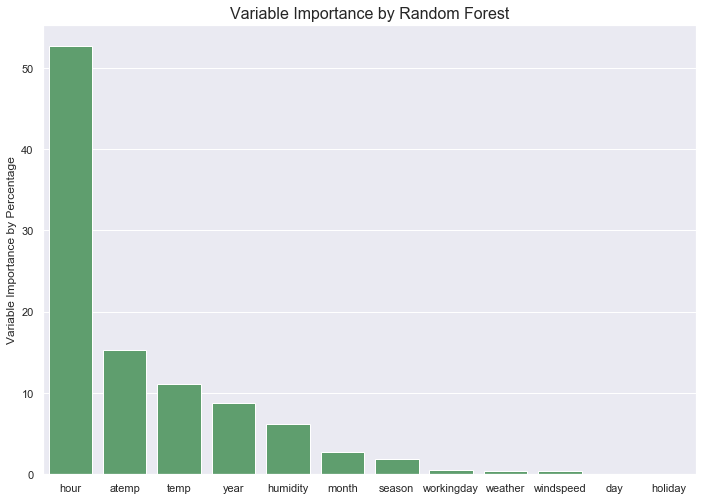

In [368]:
# Variable importances from each algorithm
# Calculate magnitude of normalized GBM coefficients
sns.set(rc={'figure.figsize':(11.7, 8.27)})
rf2_varimp = rf2.varimp()
variables, reimp, imp, imppercent = zip(*rf2_varimp)
ax = sns.barplot(x = np.array(variables), y = np.array(imppercent) * 100, color = "g")
ax.set_title('Variable Importance by Random Forest', fontsize=16)
ax.set_ylabel("Variable Importance by Percentage")
plt.show()

Hour is the most important variable by Gradient Boosting Methods.

In [353]:
# Compare the performance by removing the highly correlated variable atemp.
myX = ['season', 'holiday', 'workingday', 'weather', 'temp','humidity', 
       'windspeed', 'year', 'month', 'day', 'hour']

data_gbm = H2OGradientBoostingEstimator(balance_classes=True,
                                         ntrees         =100,
                                         max_depth      =10,
                                         learn_rate     =0.1)

data_gbm.train( x               =myX,
                y               =myY,
                training_frame  =traindata,
                validation_frame=testdata)
print(data_gbm.model_performance(testdata))

gbm Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 1529.780722387488
RMSE: 39.11241135991858
MAE: 24.72734316894246
RMSLE: NaN
Mean Residual Deviance: 1529.780722387488



Removing the highly-correlated variable atemp doesn't improve the model according to the metrics. 

## Forecasting Results

In [370]:
test = pd.read_csv("./data/test.csv")
extractTimeStamp(test)
datetime = test["datetime"]
test = test.drop(columns = ["datetime"])
test = h2o.H2OFrame(test)
res = gbm2.predict(test).as_data_frame()["predict"]
res = ["datetime,count"] + [x + "," + str(int(y)) for x, y in zip(datetime, res)]
with open("./data/testres.csv", "w", encoding="utf-8") as f:
    f.write("\n".join(res))

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


## Recommendations and Future Work

Given the forecasted demand, an optimization of bike resources allocation could be conducted. 
Also, hour turns out to be the most important feature accoring to the model, which indicates an hourly updated bike resource allocation could be possible. 

## Reference
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/faq/python.html<br/>
https://www.kaggle.com/c/bike-sharing-demand